# A Tutorial in Reinforcement Learning

In [16]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

## Quentin's world 

To demonstrate RL, we'll use a 10x10 grid world called Quentin's world. In this environment, we have 100 states and 4 possible actions: right, up, left, and down. The starting point is the green square and the goal state is in yellow. Once you get to the yellow state, you'll get a reward of 1. Moving into the red squares incurs a penalty (-1). Moving into borders of the world results in staying in the same place. Once you move past the reward state, the episode ends. 

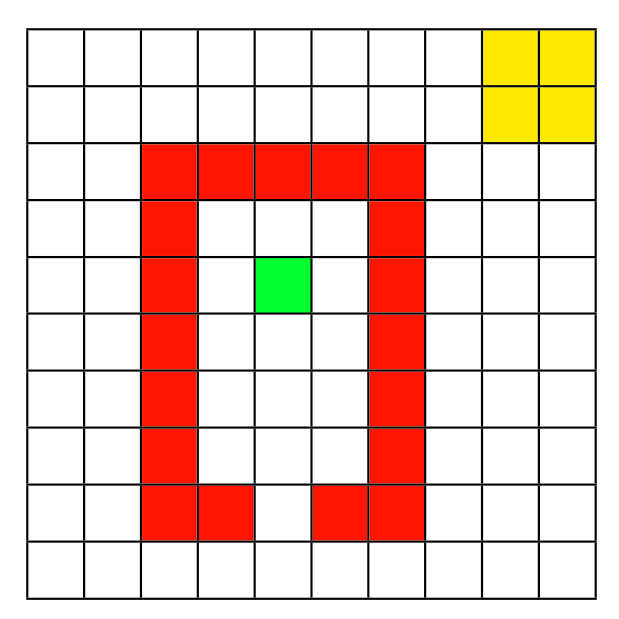

In [17]:
from IPython.display import Image
Image(filename="worlds/QuentinsWorld.png", width=300, height=300)

## N-armed bandit task

In an N-armed bandit task, there is only a single state. Our implementation is a 3-armed bandit, which means there are 3 available actions, and each one returns a different reward.

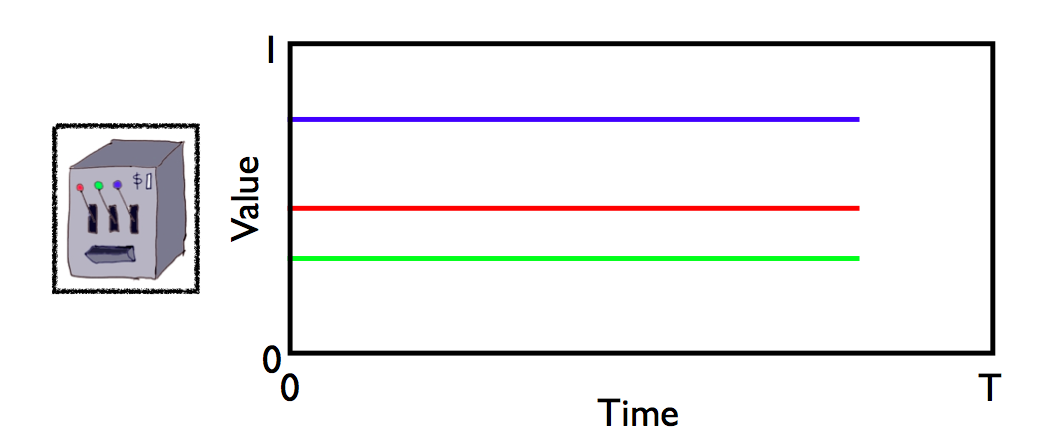

In [18]:
from IPython.display import Image
Image(filename="worlds/4ArmedBandit.png", width=600, height=225)

## Cheese world

In this one-dimensional grid there are 4 states and 2 possible actions: left and right. Arriving at the goal state gives you a reward of 1. Moving left from the start state (state 1 in the figure) stays in the same place, and moving anywhere from the goal state (state 4 in the figure) ends the episode.

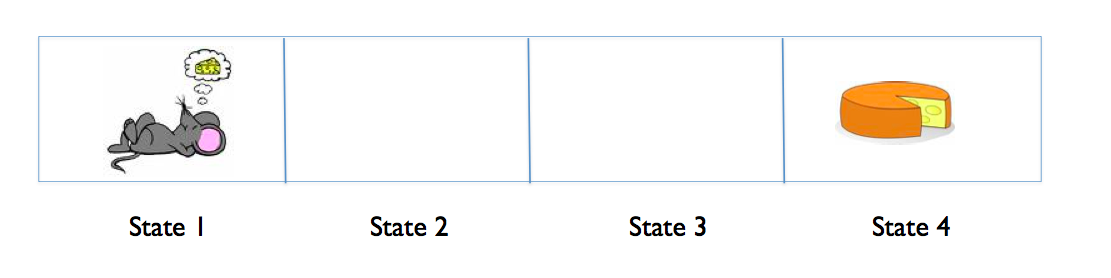

In [19]:
from IPython.display import Image
Image(filename="worlds/CheeseWorld.png", width=600, height=225)

## Cliff world

In this 4x10 grid there are 40 states and 4 possible actions: right, up, left and down. Falling off the cliff incurs a negative reward of -100 and ends the episode; moving into any other state incurs a reward of -1; moving into the world borders stays in the same place; moving anywhere from the goal state (state G in the figure) ends the episode.

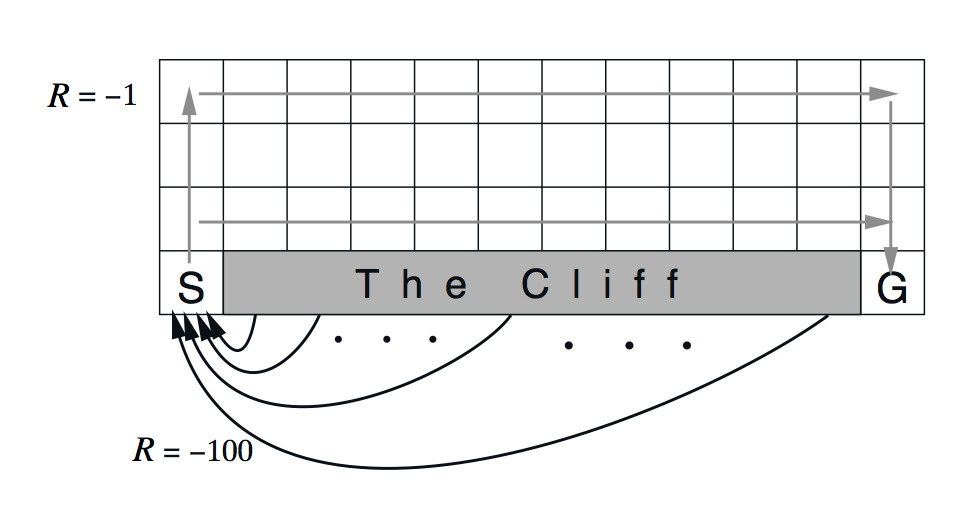

In [20]:
from IPython.display import Image
Image(filename="worlds/CliffWorld.png", width=600, height=225)

## Multi-room windy gridworld with cliffs

In this 12x14 grid there are 168 states and 4 possible actions: right, up, left and down. The start state is marked with an S in the figure, and there are 2 goals states marked with a G. Each goal state is inside a room (the room walls are marked with darker lines). Moving into a goal states gives you a reward of 100. Moving into a wall or outside the world borders stays in the same place. The two rooms are windy, which means the resultant next states inside the rooms are shifted; the wind direction is indicated by a blue arrow, and the wind strength (size of the shift) in each column is indicated by a number between 0 and 2. There are also two cliffs marked in gray; falling into a cliff incurs a reward of -100 and ends the episode. 

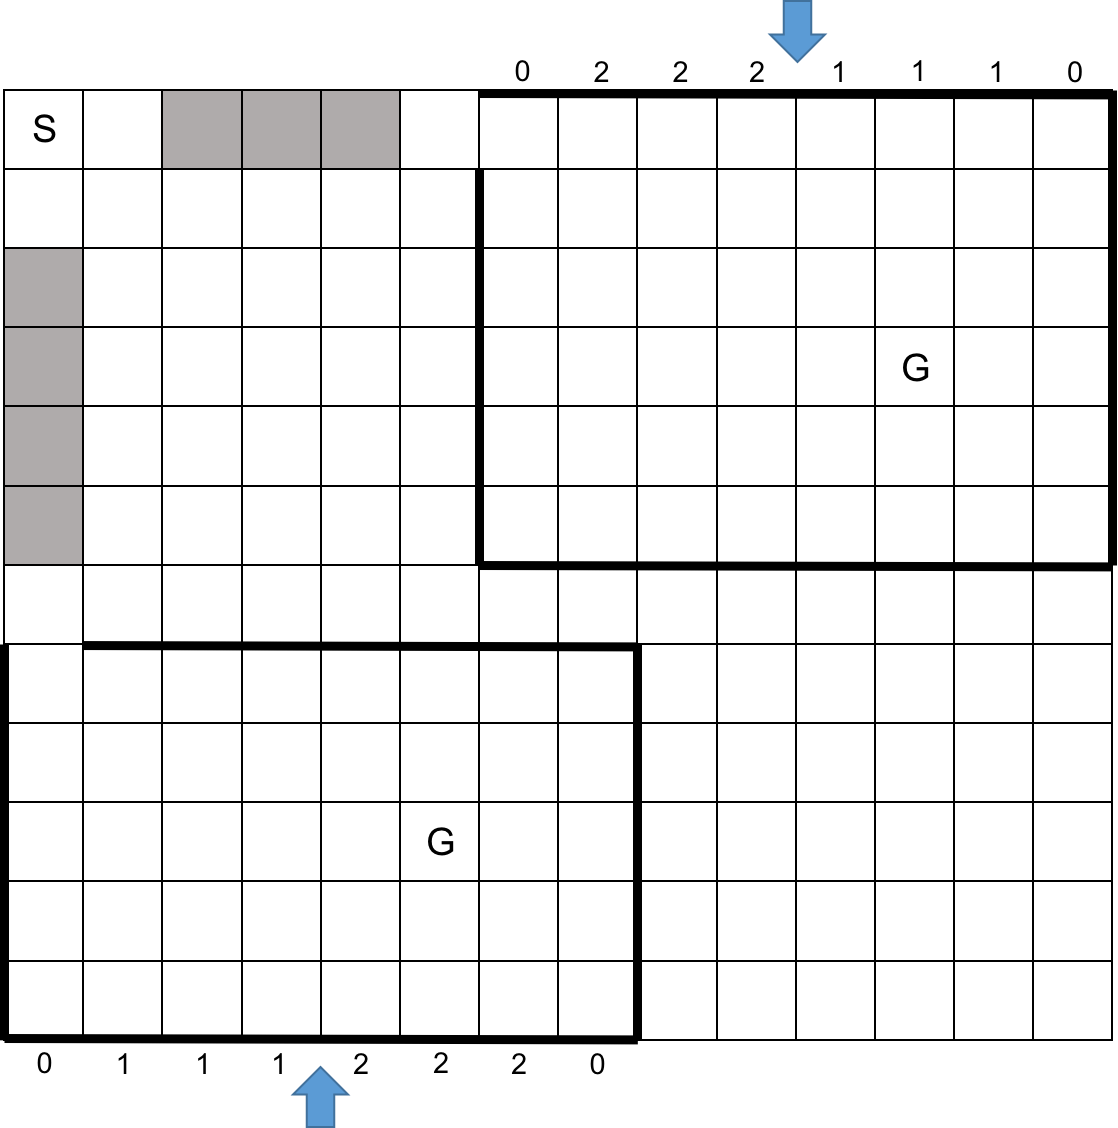

In [21]:
from IPython.display import Image
Image(filename="worlds/gridworld.png", width=451.2, height=447.2)

## Helper functions

In [22]:
# Import definitions of the environments.
import RL_worlds as worlds

# Import helper functions for plotting.
from plot_util import *

In [23]:
def default_params(environment):
    """
    Define the default parameters.
    Args:
        environment: an object corresponding to the environment.
    Returns:
        a dictionary containing the default parameters, where the keys
            are strings (parameter names).
    """
    params = dict()
    params['environment'] = environment
    
    params['alpha'] = 0.1  # learning rate    
    params['beta'] = 10  # inverse temperature    
    params['policy'] = 'epsilon_greedy'
    params['epsilon'] = 0.05  # epsilon-greedy policy    
    params['learning_rule'] = 'q_learning'
    params['epsilon_decay'] = 0.9
    
    if environment.name == 'windy_cliff_grid':
        params['gamma'] = 0.8  # temporal discount factor
    elif environment.name == 'n_armed_bandit':
        params['gamma'] = 0.9  # temporal discount factor
    elif environment.name == 'cliff_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'cheese_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'quentins_world':
        params['gamma'] = 0.9  # temporal discount factor

    return params

def update_state(state, action, params):
    """
    State transition based on world, action and current state.
    Args:
        state: integer corresponding to the current state.
        action: integer corresponding to the action taken.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the next state;
        an integer corresponding to the reward received.
    """
    next_state, reward = params['environment'].get_outcome(state, action)
    return next_state, reward

def update_value(prev_state, action, reward, state, value, params):
    """
    Update the value function.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer correspoding to action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state;
          should be None if the episode ended.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    if params['learning_rule'] == 'q_learning':
        # off policy learning
        return q_learning(prev_state, action, reward, state, value, params)
    elif params['learning_rule'] == 'sarsa':
        # on policy learning
        return sarsa(prev_state, action, reward, state, value, params)
    else:
        print('Learning rule not recognized')
    
def call_policy(state, value, params):
    """
    Call a policy to choose actions, given current state and value function.
    Args:
        state: integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding action chosen according to the policy.
    """
    # multiple options for policy
    if params['policy'] == 'epsilon_greedy':
        return epsilon_greedy(state, value, params)
    elif params['policy'] == 'softmax':
        return softmax(state, value, params)
    else: # random policy (if policy not recognized, choose randomly)
        return randint(params['environment'].n_actions)    


## Decision Policies

1. Epsilon-greedy policy function.

2. Softmax policy function.

In [24]:
def epsilon_greedy(state, value, params):
    """
    Epsilon-greedy policy: selects the maximum value action with probabilty
      (1-epsilon) and selects randomly with epsilon probability.
    Args:
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        action: an integer corresponding action chosen according to the policy.
    """
    value_now = value[state,:]
    if rand() > params['epsilon']:
        action = where(value_now == max(value_now))[0][0]
    else:
        # We deal with ties by selecting randomly.
        action = randint(len(value_now)) 
    return action

def softmax(state, value, params):
    """
    Softmax policy: selects action probabilistically depending on the value.
    Args:
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the action chosen according to the policy.
    """
    value_now = value[state,:]
    prob = exp(value_now * params['beta'])  # beta is the inverse temperature
    prob = prob / sum(prob)  # normalize
    cum_prob = cumsum(prob)  # cummulation summation
    action = where(cum_prob > rand())[0][0]
    return action

## Learning Algorithms

1. Q-learning (off-policy) algorithm.
2. Sarsa (on-policy) algorithm.


In [25]:
def q_learning(prev_state, action, reward, state, value, params):
    """
    Q-learning: updates the value function and returns it.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer corresponding to the action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    # maximum value at current state
    if state == None:
        max_value = 0
    else:
        max_value = max(value[state,:])
    
    # value of previous state-action pair
    prev_value = value[prev_state, action]
    # reward prediction error
    delta = reward + params['gamma'] * max_value - prev_value  # gamma is the temporal discount factor
    
    # update value of previous state-action pair
    value[prev_state, action] = prev_value + params['alpha'] * delta  # alpha: learning rate
    
    return value

def sarsa(prev_state, action, reward, state, value, params):
    """
    Sarsa: updates the value function and returns it.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer correspoding to action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    # select the expected value at current state based on our
    # policy by sampling from it
    if state == None:
        policy_value = 0
    else:
        # sample action from the policy for the next state
        policy_action = call_policy(state, value, params)
        # get the value based on the action sampled from the policy
        policy_value = value[state, policy_action]
    
    # value of previous state-action pair
    prev_value = value[prev_state, action]
    # reward prediction error
    delta = reward + params['gamma'] * policy_value - prev_value  # gamma is the temporal discount factor
    
    # update value of previous state-action pair
    value[prev_state, action] = prev_value + params['alpha'] * delta  # alpha: learning rate
    
    return value

## Run Learning

In [26]:
def run_learning(value, params, n_episodes, max_steps):
    """
    Args:
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
        n_episodes: integer, number of episodes to run.
        max_steps: integer, maximum number of steps to take in each episode.
    Returns:
        a dictionary where the keys are integers (episode numbers)
          and the values are integers (total rewards per episode);
        the updated value function (matrix indexed by state and action).
    """
    reward_sums = np.zeros(n_episodes)

    # Loop over episodes
    for episode in xrange(n_episodes):
        state = params['environment'].init_state    
        step = 0
        reward_sum = 0

        # Make sure to break after max number of steps
        while step < max_steps:
            action = call_policy(state, value, params)  # get action from policy
            next_state, reward = update_state(state, action, params)  # update state based on action
            value = update_value(state, action, reward, next_state, value, params)  # update value function
            state = next_state
            reward_sum += reward  # sum rewards obtained
            step += 1
            if next_state == None:
                break  # episode ends

        reward_sums[episode] = reward_sum

    return reward_sums, value

## Init & Plot

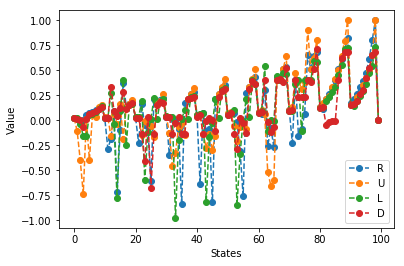

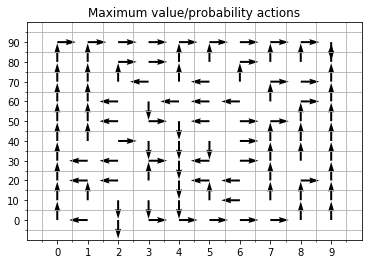

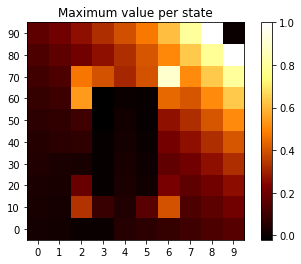

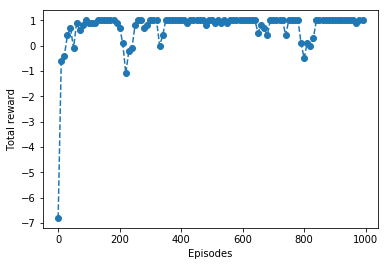

In [28]:
# Choose a world
# env = worlds.n_armed_bandit()
# env = worlds.cheese_world()
# env = worlds.cliff_world()
env = worlds.quentins_world()
#env = worlds.windy_cliff_grid()

# Default parameters
params = default_params(environment=env)

# Choose a policy, a learning rule and parameter values
params['learning_rule'] = 'sarsa'
params['policy'] = 'epsilon_greedy'
params['epsilon'] = 0.01
params['alpha'] = 0.5
params['beta'] = 10
params['gamma'] = 0.8

# Episodes/trials
n_episodes = 1000
max_steps = 1000

# Initialization - Start with uniform value function
value = np.ones((env.n_states, env.n_actions))

# Run learning
reward_sums, value = run_learning(value, params, n_episodes, max_steps)

fig = plot_state_action_values(env, value)
fig = plot_quiver_max_action(env, value)
fig = plot_heatmap_max_val(env, value)
fig = plot_rewards(n_episodes, reward_sums, average_range=10)